# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
#lemmatize
import nltk
from nltk import word_tokenize 
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 

nltk.download('stopwords', quiet=True, raise_on_error=True)
stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles) if t not in stop_words]
    
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
#     hv = HashingVectorizer(tokenizer=LemmaTokenizer(), n_features=2 ** 20, alternate_sign=False, strip_accents='ascii', analyzer='word', ngram_range=(1,2))
    hv = CountVectorizer(tokenizer=LemmaTokenizer(), strip_accents='ascii', ngram_range=(1,2), lowercase=True, max_df = 0.5, min_df = 10, stop_words=tokenized_stop_words)


    X_hv = hv.fit_transform(movie_data.review)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer(sublinear_tf=True)
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    movie_data['exclam_count'] = movie_data['review'].str.count("\!")
    movie_data['q_count'] = movie_data['review'].str.count("\?")
    movie_data['q_star'] = movie_data['review'].str.count("\*")
    movie_data['q_hash'] = movie_data['review'].str.count("\#")
    
    # uppercase letter count
    import string
    movie_data['upper'] = [sum(1 for letter in c if letter.isupper()) for c in movie_data['review']]
    
    #afinn sentiment dictionary score from modifierd dictionary of only negative sentiment words
    from afinn import Afinn
    afn = Afinn()
    
    movie_data['afinn_score'] = [afn.score(c) for c in movie_data['review']]

    X_quant_features = movie_data[["word_count", "punc_count",'exclam_count','q_count','upper','q_star','q_hash','afinn_score']]
    
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = movie_data['sentiment']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Create training and test sets from function

In [4]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=80)

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 55755)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclam_count  q_count  upper  q_star  q_hash  \
0         433          20             1        2     59       0       0   
1      

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 5341, 'TN': 4937, 'FP': 5106, 'FN': 4616, 'Accuracy': 0.5139, 'Precision': 0.5112472480137839, 'Recall': 0.5364065481570754, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(alpha=5, max_iter=10000)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9813, 'TN': 9876, 'FP': 167, 'FN': 144, 'Accuracy': 0.98445, 'Precision': 0.9832665330661323, 'Recall': 0.9855378125941548, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log',alpha=1)
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9921, 'TN': 10016, 'FP': 27, 'FN': 36, 'Accuracy': 0.99685, 'Precision': 0.997285886610374, 'Recall': 0.9963844531485387, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9537, 'TN': 9643, 'FP': 400, 'FN': 420, 'Accuracy': 0.959, 'Precision': 0.9597464023347086, 'Recall': 0.957818620066285, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron',alpha=1)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9953, 'TN': 10043, 'FP': 0, 'FN': 4, 'Accuracy': 0.9998, 'Precision': 1.0, 'Recall': 0.9995982725720599, 'desc': 'prc_train'}


### Model: Neural Network Perceptron

In [10]:
# from sklearn import neural_network

# prc = neural_network.MLPClassifier()
# prc.fit(X_train, y_train)

# prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
# prc_performance_train.compute_measures()
# print(prc_performance_train.performance_measures)

### MODEL: Ridge Regression Classifier

In [11]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1, normalize=True)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10042, 'FP': 1, 'FN': 0, 'Accuracy': 0.99995, 'Precision': 0.9998995782285599, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=1000, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 9957, 'Neg': 10043, 'TP': 9850, 'TN': 10018, 'FP': 25, 'FN': 107, 'Accuracy': 0.9934, 'Precision': 0.9974683544303797, 'Recall': 0.9892537913026012, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

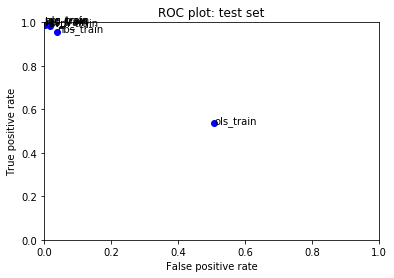

In [13]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [14]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [15]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
7
After Watergate, Vietnam and the dark days of the Nixon and Jimmy Carter eras, what the world needed was a good old-fashioned chapter-play hero taking on venomous serpents and evildoers in the America of 1936 or the jungles of South America in a series of fantastic cliffhanging adventures. Unfortunately what it got in 1975 was Doc Savage, The Man of Bronze. Perhaps the best that can be said of legendary producer George Pal's final film is that his often beautifully designed but sadly flat adaptation of Kenneth Robeson's pulp-paperback novels probably had George Lucas and Phil Kaufman leaving the theatre and saying to each other \We can do better than that,\" and adding a bullwhip, a battered Fedora and some much needed character flaws to the mix.<br /><br />A big part of the problem is that Doc Savage is in many ways even harder to write for than Superman  explorer, adventurer, philanthropist, a scientific and intellectual genius in the bronzed bleach-bl

812
Bamboo House of Dolls (1973, 1974 or 1977, various years are given for this title) is a Hong Kong veteran Chin Hung Kuei's (Killer Snakes, Boxer's Omen, Payment in Blood etc.) women in prison flick produced by the legendary Shaw Brothers. Yes, even they got their hands into low exploitation sickies like this, and Bamboo is definitely among the worse attempts of the whole genre, even when compared to the Western attempts that usually pale in comparison with the Eastern films!<br /><br />The story is about a Japanese war camp in which the Chinese women are brutalized, abused and raped by the bad Japanese (what else?) during the World War II. The girls also know a secret place in which a box full of gold is hidden and also learn that a Chinese military officer raised in Japan (Shaw veteran Lo Lieh) is actually now an undercover agent among the other Japanese and naturally helps the girls escape the hell. What follows is sequences full of gratuitous nudity, female kung fu, some nasty t

3205
The film lacks style, i mean original style. everything looks copied including action, first appearances in the movie, songs, dialog delivery, etc etc. Yes, there the goof-ups were original, like in the beginning a car is shown with number UP**** number and few seconds later it starts falling down a hill with number MH**** . That was one in many goof-ups of the movie :) Anything good in the movie? yes, for kareena fans, if there are any, Kareena in bikini. For akshay fans, his dialogs and action stunts. Thats it. nothing else. So watch it on your own risk and don't blame the director or actors. Director is already insane and actors, i pity them.
* * * * * * * * * 
3265
Ursula Andress' naked body is one of those things that make you believe in God. The other two women (especially the one who plays the maid) have great bodies as well. Then why is the higher grade that I can give to a film with such quality and quantity of nudity only 3 out of 10? Because, to get to Ursula's unbeliev

6154
Around the late 1970's, animator Don Bluth, frustrated with the output his company, Disney was churning, defected from the Mouse House to form his own studio. His first production, THE SECRET OF NIMH, was a brilliant feature that still holds up well to this day. This was followed by AN American TAIL and THE LAND BEFORE TIME, both of which were made under the involvement of Steven Spielberg and were commercially successful. Although none of those two films had the dark adult appeal of NIMH, they still are very charming, enjoyable features for both children and grown-ups. But before long, Don Bluth had his first major misfire with ALL DOGS GO TO HEAVEN; critics were especially harsh on this film, and matters weren't helped by the fact that it opened alongside Disney's THE LITTLE MERMAID.<br /><br />Considering that the movie has such a friendly-sounding title, one would expect ALL DOGS GO TO HEAVEN to be pleasant family fare. Instead Bluth provides a surprisingly dark story involvin

7059
Repetitive music, annoying narration, terrible cinematography effects. Half of the plot seemed centered around shock value and the other half seemed to be focused on appeasing the type of crowd that would nag at people to start a fight.<br /><br />One of the best scenes was in the \deleted scenes\" section, the one where she's in the principle's office with her mom. I don't understand why they'd cut that. The movie seemed desperate to make a point about anything it could and Domino talking about sororities would have been a highlight of the movie.<br /><br />Ridiculous camera work is reminiscent of MTV, and completely not needed or helpful to a movie. Speeding the film up just to jump past a lot of things and rotating the camera around something repeatedly got old the first time it was used. It's like the directors are wanting to use up all this extra footage they didn't want to throw away.<br /><br />Another movie with Jerry Springer in it? That should've told me not to watch it 

9404
***Comments contain spoilers*** I was barely holding on to this show as appointment TV when they started the annoying music under EVERY SCENE, when Don Epps was averaging almost a shooting per case, when the very nasally Diane Farr was obviously pregnant (but we weren't to notice) and when Colby was a f*****g TRIPLE agent. But now, in tonight's episode,David is trapped with a paranoid, nut job who is an OBVIOUS amateur with a gun, in an elevator and....HE CAN'T DISARM HIM. A trained, experienced field agent who has been 1st through the door many times and is experienced in hand-to-hand fighting, CAN'T TAKE OUT A NUT JOB. Not when said nut job blinks, looks away, drops his head, closes his eyes; not even when he looks up at the fiber optic wire wriggling around the ceiling like a stripper on a pole for 20 seconds.<br /><br />Then the scene came that let me know that as much as I enjoy learning from the chubby, frumpish but very charming Charles Epps and his sexy sidekick/love inter

12163
This film is justly famous as one of the most horrible examples of propaganda ever produced. The insistent equation of Jews with disease is simply<br /><br />pathological, and even worse it almost becomes believable for brief seconds<br /><br />through its sheer repetition. The fact that something this crude works, even<br /><br />briefly, is an object lesson in itself. You have to have a strong stomach and a firm grip on yourself to sit through this, and I wouldn't recommend trying unless you have a good reason.
* * * * * * * * * 
12168
In THE FAN Robert De Niro plays Gil Renard . Or is it Travis Bickle ? or Rupert Pupkin ? Or Max Cady ? You see the problem with this type of role is that De Niro has played very very similar characters in TAXI DRIVER , THE KING OF COMEDY and CAPE FEAR and unfortunately the characters were better developed and had better scripts . I found it slightly difficult to believe that Renard would have started out as a frustrated obsessive sports fan into 

13134
Serge Farnel made a very precise critics of this film in the revue \The Rwandese night\" (www.lanuitrwandaise.net)<br /><br />A critics which shows how France was behind all the situation undergone by the United Nations in Rwanda.<br /><br />The UN soldiers were in a dangerous situation while the french soldiers were warmly welcomed by the genocide forces.<br /><br />The day before, ten UN soldiers had been killed by the genocide forces.<br /><br />That is why the UN soldiers decided to protect their own lives by driving behind the french trucks.<br /><br />By doing so, they gave up the Tutsi which is unforgivable of course.<br /><br />But we must keep in mind that the french soldiers organized this situation."
* * * * * * * * * 
13151
This is an embarrassment to everyone and everything used in making this joke. I personally don't care one way or another about Jessica Simpson and her talent or whatever so many people find fascinating about her. Just as a movie this is something t

15062
Sniffing girl's panties kills a guy...and a stupid freaky puppet says a lot of stupid freaky things......My eyes could not leave the screen, my finger could not leave the Fast Forward button....I had to rewatch this spectacle to see if I had really experienced what I thought...I did.....God help us all!
* * * * * * * * * 
15158
Mere thoughts of \Going Overboard\" (aka \"Babes Ahoy\") make me want to weep. Throwing yourself out a window would be better than watching this movie. It's not even a supposed \"so bad it's good\" movie. I would spend money to buy copies of this movie and burn them so that people can't see it. Oh the pain, the pain..."
* * * * * * * * * 
15226
This is one of the worst B slashers I've ever seen in my life. The ending is something you have to see to believe.<br /><br />The movie starts with Harry Standing and Phillip Standing sitting on the stairs with their mother watching their father come down the chimney while dressed in a Santa suit. He puts the presen

15931
In the wake of Lock, Stock and Two Smoking Barrels, the British film industry rapidly became swamped with bad gangster films in the late '90s-early '00s that seem even more desperate today than they did then. In one of the all-time great cases of pearls-from-swine, the producers of Rancid Aluminium brazenly plastered the quote 'The best film of the century' from one review all over the ads while omitting the rest of the sentence pointing out that that was only because, at the time of writing, it was the only film that had been released in 2000. Looking at it today it's hard to imagine how it ever got made, uniting a cast that was briefly considered the cream of Cool Britannia's Lads Mags Brigade  Rhys Ifans, Sadie Frost, Nick Moran and Joseph Fiennes  but now merely a guarantee of a turkey every time in a confused adaptation of a confused James Hawes novel. That the plot is never explained could be down to the possibility that no-one really knows what it is, or perhaps simply d

18016
The fifth \Black Emanuelle\" I've watched has, potentially, the most intriguing plot line dealing as it does with the intrepid female reporter investigating the white slavery/prostitution racket which takes her from San Francisco to Rome to Macao and back to her own hometown, New York! The film is peopled with past veterans of the series which, inexplicably, play completely different roles, namely Ivan Rassimov (appearing here as a head of a United Nations committee for Third World countries!), Karin Shubert (as a feminist rival reporter) and Don Powell (as Rassimov's chauffeur).<br /><br />Unfortunately, as usual with this type of film (despite their being shown in the dead of night), it is heavily edited and a particularly graphic scene (described in \"Stracultr) in which an Asian slave trader gets his comeuppance by being sodomized by a dog is nowhere to be seen here!! Still, a harrowing sequence late in the film when a sleazy politician tricks a couple of girls (including, na

19200
This TV film tells the story of extrovert Frannie suddenly returning to Silk Hope to visit friends and family, but unaware of her mother's death. Her sister runs the family home, but is intending to sell it and move away with her new husband. Frannie strongly objects to the idea, and vows to keep the family heirloom as it were, by getting a job and maintaining responsibility.<br /><br />In comes handsome Ruben and the two soon fall in love (as you do), and it's from this point that I sort of lost interest....<br /><br />There is more to Farrah Fawcett than just the blonde hair and looks, she can portray a character extremely convincingly when she puts her mind to it - and it is certainly proved here as well as some of her previous efforts like Extremities and Small Sacrificies - a great performance from the legendary Charlie's Angel.<br /><br />Silk Hope is the type of film that never shies away from its cheap and cheerful TV image, and you know there was a limit to the budget, b

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [16]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1443, 'TN': 1183, 'FP': 1274, 'FN': 1100, 'Accuracy': 0.5252, 'Precision': 0.5311004784688995, 'Recall': 0.5674400314589068, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [17]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2303, 'TN': 2195, 'FP': 262, 'FN': 240, 'Accuracy': 0.8996, 'Precision': 0.8978557504873295, 'Recall': 0.9056232795910342, 'desc': 'svm_test'}


### MODEL: logistic regression

In [18]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2285, 'TN': 2207, 'FP': 250, 'FN': 258, 'Accuracy': 0.8984, 'Precision': 0.9013806706114399, 'Recall': 0.8985450255603618, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [19]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2168, 'TN': 2142, 'FP': 315, 'FN': 375, 'Accuracy': 0.862, 'Precision': 0.8731373338703181, 'Recall': 0.852536374360991, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [20]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2164, 'TN': 2113, 'FP': 344, 'FN': 379, 'Accuracy': 0.8554, 'Precision': 0.8628389154704944, 'Recall': 0.8509634290208415, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [21]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2236, 'TN': 2162, 'FP': 295, 'FN': 307, 'Accuracy': 0.8796, 'Precision': 0.8834452785460293, 'Recall': 0.8792764451435313, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [22]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1852, 'TN': 2096, 'FP': 361, 'FN': 691, 'Accuracy': 0.7896, 'Precision': 0.8368730230456394, 'Recall': 0.728273692489186, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

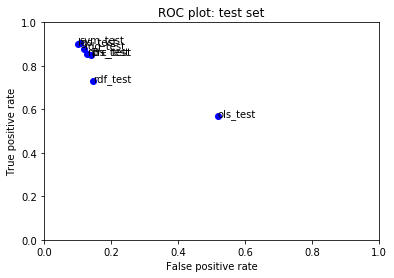

In [23]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [24]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=80, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 54532)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclam_count  q_count  upper  q_star  q_hash  \
0         131           5             0        0      7       0       0   
1         169          15             1        0     15       0       0   
2         176          18             0        0     25       0   

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [27]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

ValueError: X has 54540 features per sample; expecting 55763

In [ ]:
raw_data.head()

In [ ]:
my_submission.head()

In [ ]:
my_submission.shape

In [ ]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation